In [441]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

from utils.data_generation import generate_vectors, generate_scalars
from benchmark_functions.sphere import sphere_func
from neural_network_models.feedforward_nn import FeedforwardNN
from utils.number_comparison import order_of_magnitude

## Generating data

In [442]:
np.random.seed(1000)
torch.manual_seed(1000)

In [443]:
input_dimention = 2
domain = [-1, 1]

data_set_size = 100
training_set_fraction = 0.7
validation_set_fraction = 0.15
test_set_fraction = 0.15

In [444]:
# generate training data
data_set_vectors = generate_vectors(input_dimention, domain, data_set_size)
data_set_scalars = generate_scalars(data_set_vectors, sphere_func)

# separate training data from validation and test data
training_set_vectors, temp_set_vectors, training_set_scalars, temp_set_scalars = train_test_split(
    data_set_vectors, 
    data_set_scalars, 
    test_size = (validation_set_fraction + test_set_fraction), 
    random_state = 42
)

# separate validation data from test data
validation_set_vectors, test_set_vectors, validation_set_scalars, test_set_scalars = train_test_split(
    temp_set_vectors, 
    temp_set_scalars, 
    test_size = (test_set_fraction / (test_set_fraction + validation_set_fraction)), 
    random_state = 42
)

## Data pre-processing

In [445]:
vector_scaler = MinMaxScaler().fit(training_set_vectors)
scalar_scaler = StandardScaler().fit(training_set_scalars.reshape(-1, 1))

In [446]:
training_set_vectors = vector_scaler.transform(training_set_vectors)
validation_set_vectors = vector_scaler.transform(validation_set_vectors)
test_set_vectors = vector_scaler.transform(test_set_vectors)

In [447]:
training_set_scalars = scalar_scaler.transform(training_set_scalars.reshape(-1, 1))
validation_set_scalars = scalar_scaler.transform(validation_set_scalars.reshape(-1, 1))
test_set_scalars = scalar_scaler.transform(test_set_scalars.reshape(-1, 1))

In [448]:
# convert generated data to tensors
training_set_vectors = torch.FloatTensor(training_set_vectors)
training_set_scalars = torch.FloatTensor(training_set_scalars)

validation_set_vectors = torch.FloatTensor(validation_set_vectors)
validation_set_scalars = torch.FloatTensor(validation_set_scalars)

test_set_vectors = torch.FloatTensor(test_set_vectors)
test_set_scalars = torch.FloatTensor(test_set_scalars)

## Creating a model

In [449]:
model = FeedforwardNN(input_neuron_num = input_dimention, h1_neuron_num = 9, output_neuron_num = 1)

loss_func = nn.MSELoss()
loss_optimization_func = optim.Adam(model.parameters(), lr = 0.05)

In [450]:
training_losses = []
validation_losses = []

best_validation_loss = float("inf")
best_model_state = any

patience_limit = 3
patience_tries = 0
tolerance = 1e-5
epoch_limit = 400

for epoch in range(epoch_limit):
    # pass forward
    training_set_predictions = model(training_set_vectors)
    training_loss = loss_func(training_set_predictions, training_set_scalars)
    training_losses.append(training_loss.item())

    # back-propagation
    loss_optimization_func.zero_grad()
    training_loss.backward()
    loss_optimization_func.step()

    # validation step
    model.eval()

    with torch.no_grad():
        validation_set_predictions = model(validation_set_vectors)
        validation_loss = loss_func(validation_set_predictions, validation_set_scalars)
        validation_losses.append(validation_loss.item())
    
    if (epoch + 1) % 50 == 0:
        print(f"[{epoch + 1}] Training loss: {training_loss.item():.6f} | Validation loss: {validation_loss.item():.6f}")

    if validation_loss.item() < best_validation_loss - tolerance:
        best_val_loss = validation_loss.item()
        patience_tries = 0 
    else:
        patience_tries += 1
        
        if patience_tries >= patience_limit:
            break

[50] Training loss: 0.957565 | Validation loss: 0.979295
[100] Training loss: 0.740254 | Validation loss: 0.919769
[150] Training loss: 0.389103 | Validation loss: 0.441791
[200] Training loss: 0.035073 | Validation loss: 0.027890
[250] Training loss: 0.007742 | Validation loss: 0.014699
[300] Training loss: 0.002935 | Validation loss: 0.008006
[350] Training loss: 0.001643 | Validation loss: 0.005304
[400] Training loss: 0.001193 | Validation loss: 0.004048


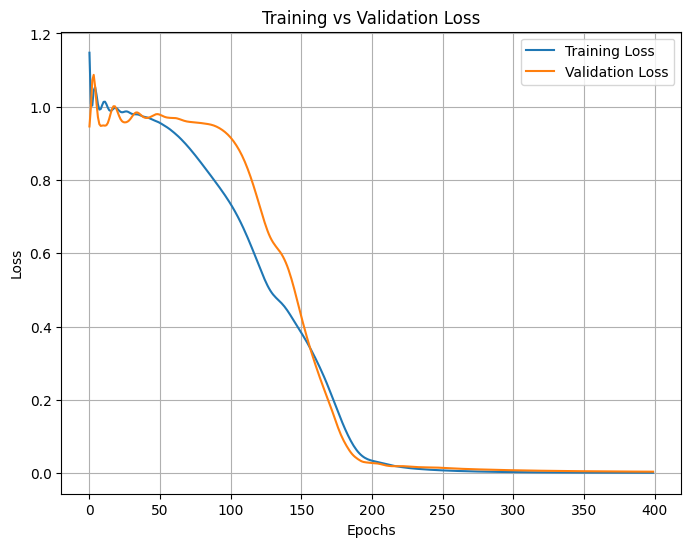

In [451]:
plt.figure(figsize = (8, 6))

plt.plot(training_losses, label = 'Training Loss')
plt.plot(validation_losses, label = 'Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.grid(True)

plt.show()

In [452]:
model.eval()

with torch.no_grad():
    test_set_predictions = model(test_set_vectors)
    test_loss = loss_func(test_set_predictions, test_set_scalars)
    print("Test loss (MSE): ", test_loss.item())

Test loss (MSE):  0.004767606966197491


In [453]:
absolute_errors = torch.abs(test_set_predictions - test_set_scalars)

# mean
error_mean = torch.mean(absolute_errors)
print(f"Test set absolute error min: {error_mean}")

# min
min_error = torch.min(absolute_errors)
print(f"Test set absolute error min: {min_error}")

# max
max_error = torch.max(absolute_errors)
print(f"Test set absolute error max: {max_error}")

# standard deviation
error_std = torch.std(absolute_errors)
print(f"Test set absolute error standard deviation: {error_std}")

Test set absolute error min: 0.04426393285393715
Test set absolute error min: 0.001301884651184082
Test set absolute error max: 0.2078993320465088
Test set absolute error standard deviation: 0.05485348775982857
